---
title: "Assignment 1"
author: "Agustina Albez, Bora Abdik, Liam Hoogstad, Nour El Arrasse and Nurul Putri"
date: "2025-10-06"
format: pdf
---
\newpage
\tableofcontents
\listoffigures
\listoftables
\newpage

# Import libraries

In [1]:
# Imports:

#| warning: false
#install.packages(c("dplyr", "ggplot2", "PerformanceAnalytics"))
#install.packages(c("glue"))
#install.packages(c("lubridate"))

library(dplyr)
library(ggplot2)
library(PerformanceAnalytics)
library(lubridate)
library(glue)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to

# Part 1

### Definition of columns

| Column       | Meaning                                                                                                             |
| ------------ | ------------------------------------------------------------------------------------------------------------------- |
| **GVKEY**    | Permanent unique company identifier in Compustat (stays the same even if ticker changes).                           |
| **iid**      | Issue identifier — distinguishes multiple securities for the same GVKEY (e.g., different share classes).            |
| **datadate** | Date of the observation (daily frequency here).                                                                     |
| **tic**      | Ticker symbol (e.g., PBPB = Potbelly Corp).                                                                         |
| **conm**     | Company name.                                                                                                       |
| **cshtrd**   | Daily trading volume (number of shares traded).                                                                     |
| **prccd**    | Closing price (adjusted close price per share at market close).                                                     |
| **prchd**    | High price of the day.                                                                                              |
| **prcld**    | Low price of the day.                                                                                               |
| **prcod**    | Opening price of the day.                                                                                           |
| **exchg**    | Exchange code (numeric code for which exchange the stock is traded on, e.g., 14 = NASDAQ).                          |
| **sic**      | Standard Industrial Classification code (4-digit industry classification, here 5812 = Eating Places / Restaurants). |

## Import data

In [2]:
# Load stock data into dataframe
data <- read.csv("compustat_food_bev.csv")
head(data)

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,186785,1,01/09/2020,ARCO,ARCOS DORADOS HOLDINGS INC,813895,4.47,4.540,4.394,4.41,11,5812
2,186785,1,02/09/2020,ARCO,ARCOS DORADOS HOLDINGS INC,518021,4.48,4.522,4.400,4.49,11,5812
3,186785,1,03/09/2020,ARCO,ARCOS DORADOS HOLDINGS INC,947825,4.44,4.525,4.360,4.48,11,5812
4,186785,1,04/09/2020,ARCO,ARCOS DORADOS HOLDINGS INC,534286,4.41,4.490,4.280,4.48,11,5812
5,186785,1,08/09/2020,ARCO,ARCOS DORADOS HOLDINGS INC,669380,4.27,4.415,4.260,4.34,11,5812
6,186785,1,09/09/2020,ARCO,ARCOS DORADOS HOLDINGS INC,1152416,4.38,4.420,4.270,4.27,11,5812


## Chipotle Analysis


#### Loading Stock Data and Obtaining Chipotle Specific Data

In [3]:
# Filter rows where tic = "CMG"
chipotle_data <- filter(data, tic == "CMG")

# Checking for correct sample
# head(chipotle_data)

#### Daily Return Column

In [4]:
# Add Prev Day Returns
chipotle_data$prev_close = lag(chipotle_data$prccd)

# Calculating daily return based on return formula
chipotle_data$daily_return <- (chipotle_data$prccd - chipotle_data$prev_close) / chipotle_data$prev_close

#### Volume Change Column

In [5]:
# Calculating volume change based on volume change formula
chipotle_data$volume_change <- chipotle_data$cshtrd - lag(chipotle_data$cshtrd)

#### 10 Day Momentum Column

In [6]:
# Calculating 10 day momentum based on 10 day momentum formula
chipotle_data$momentum10 <- chipotle_data$prccd - lag(chipotle_data$prccd, n = 10)

#### Money Flow Volume Indicator

In [7]:
# Calculating MFV based on MFV formula
chipotle_data$MFV <- ( ((chipotle_data$prccd - chipotle_data$prcld) - (chipotle_data$prchd - chipotle_data$prccd)) / 
    (chipotle_data$prchd - chipotle_data$prcld) ) * chipotle_data$cshtrd

#### Month and Year Column

In [8]:
# Changing date strings to 'date' types
chipotle_data$datadate <- as.Date(chipotle_data$datadate, format = "%d/%m/%Y")

# Finding month and year using lubridate library
chipotle_data$month <- month(chipotle_data$datadate)
chipotle_data$year <- year(chipotle_data$datadate)

#### Total Trading Volume

In [9]:
CMG_Jun_2023_TradeVolume <- chipotle_data %>%
    filter(month == 6, year == 2023) %>% # Narrow down to June 2023
    pull(cshtrd) %>% # Narrow down to specific cshtrd column
    sum(na.rm = TRUE) # Sum cshtrd for June 2023

#### Mean Daily Return

In [10]:
CMG_MeanReturn <- chipotle_data %>%
    pull(daily_return) %>% # Narrow to daily return column
    mean(na.rm = TRUE) # Find mean of daily return column

#### Finding date with largest positive high price

In [11]:
# Find max chipotle stock price
highest_prchd <- chipotle_data %>%
  filter(prchd == max(prchd, na.rm = TRUE)) 

#### Finding date with largest positive daily return

In [12]:
# Finding max chipotle daily return
highest_daily_return <- chipotle_data %>%
  filter(daily_return == max(daily_return, na.rm = TRUE))

#### Results

In [13]:
# Removing rows with NA values from the chipotle data
chipotle_data <- na.omit(chipotle_data)
head(chipotle_data, n = 10)

# Printing Results:
print(glue("Total trading volume: {CMG_Jun_2023_TradeVolume}"))
print(glue("Mean Daily Return was: {round(CMG_MeanReturn * 100, 2)}%"))
print(glue("The highest positive price was {highest_prchd$prchd} on {highest_prchd$datadate}"))
print(glue("The highest daily return was {round(highest_daily_return$daily_return * 100, 2)}% on {highest_daily_return$datadate}"))

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,prev_close,daily_return,volume_change,momentum10,MFV,month,year
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
11,165914,1,2020-09-16,CMG,CHIPOTLE MEXICAN GRILL INC,304671,1265.87,1286.840,1264.130,1286.46,11,5812,1277.36,-0.008995115,-24237,-106.35,-257984.29,9,2020
12,165914,1,2020-09-17,CMG,CHIPOTLE MEXICAN GRILL INC,452106,1225.37,1251.390,1209.030,1240.74,11,5812,1265.87,-0.031993807,147435,-153.66,-103314.12,9,2020
13,165914,1,2020-09-18,CMG,CHIPOTLE MEXICAN GRILL INC,783291,1215.48,1247.360,1200.940,1231.00,11,5812,1225.37,-0.008071032,331185,-113.25,-292595.13,9,2020
14,165914,1,2020-09-21,CMG,CHIPOTLE MEXICAN GRILL INC,308638,1206.52,1207.810,1180.000,1194.24,11,5812,1215.48,-0.007371573,-474653,-107.21,280004.81,9,2020
15,165914,1,2020-09-22,CMG,CHIPOTLE MEXICAN GRILL INC,302318,1234.58,1242.640,1215.370,1223.83,11,5812,1206.52,0.023256970,-6320,-65.17,123610.04,9,2020
16,165914,1,2020-09-23,CMG,CHIPOTLE MEXICAN GRILL INC,530067,1248.39,1290.931,1240.440,1250.33,11,5812,1234.58,0.011185990,227749,-72.64,-363145.20,9,2020
17,165914,1,2020-09-24,CMG,CHIPOTLE MEXICAN GRILL INC,239927,1229.28,1245.930,1215.524,1239.49,11,5812,1248.39,-0.015307716,-290140,-79.21,-22833.32,9,2020
18,165914,1,2020-09-25,CMG,CHIPOTLE MEXICAN GRILL INC,234374,1244.50,1253.480,1217.390,1223.86,11,5812,1229.28,0.012381231,-5553,-52.97,117739.00,9,2020
19,165914,1,2020-09-28,CMG,CHIPOTLE MEXICAN GRILL INC,196157,1263.35,1274.940,1243.500,1263.16,11,5812,1244.50,0.015146645,-38217,-3.84,51534.89,9,2020


Total trading volume: 5392605


Mean Daily Return was: 0.07%
The highest positive price was 2175.01 on 2023-07-19
The highest daily return was 14.7% on 2022-07-27


### Chipotle Commentary

#### Date with highest positive price
On July 18 2023, Chipotle announced franchise expansion into the middle east "to accelerate [their] expansion efforts" (Chipotle Mexican Grill, 2023). The company would initially open restaurants in Dubai and Kuwait, and then open further restaurants if those proved successful(Chipotle Mexican Grill, 2023).

#### Date with highest positive daily return
*To Be Added*


## Dominos Pizza

In [14]:
dpz_data = filter(data, tic == "DPZ")

dpz_data$datadate = as.Date(dpz_data$datadate, format = '%d/%m/%Y')
head(dpz_data)

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,160211,2,2020-09-01,DPZ,DOMINO'S PIZZA INC,502471,410.15,411.720,405.6500,408.44,11,5812
2,160211,2,2020-09-02,DPZ,DOMINO'S PIZZA INC,585397,403.60,413.180,402.6200,409.86,11,5812
3,160211,2,2020-09-03,DPZ,DOMINO'S PIZZA INC,799206,397.50,403.310,389.6400,403.00,11,5812
4,160211,2,2020-09-04,DPZ,DOMINO'S PIZZA INC,857808,381.81,401.200,376.3301,397.61,11,5812
5,160211,2,2020-09-08,DPZ,DOMINO'S PIZZA INC,682847,376.32,386.645,376.1100,381.57,11,5812
6,160211,2,2020-09-09,DPZ,DOMINO'S PIZZA INC,594344,382.07,387.690,380.4800,382.50,11,5812


In [15]:
dpz_data$daily_return = (dpz_data$prccd / lag(dpz_data$prccd)) -1 

dpz_data$change_volume = dpz_data$cshtrd - lag(dpz_data$cshtrd)

dpz_data$change_open_close = dpz_data$prccd - dpz_data$prcod

dpz_data$MFV = (((dpz_data$prccd - dpz_data$prcld) - (dpz_data$prchd - dpz_data$prccd)) / (dpz_data$prchd - dpz_data$prcld)) * dpz_data$cshtrd

dpz_data_display = select(dpz_data, datadate, daily_return, change_volume, change_open_close, MFV)

head(dpz_data_display)

,datadate,daily_return,change_volume,change_open_close,MFV
,<date>,<dbl>,<int>,<dbl>,<dbl>
1,2020-09-01,NA,NA,1.71,242543.7
2,2020-09-02,-0.01596977,82926,-6.26,-476743.8
3,2020-09-03,-0.01511397,213809,-5.50,119851.7
4,2020-09-04,-0.03947170,58602,-15.80,-479784.6
5,2020-09-08,-0.01437888,-174961,-5.25,-655623.9
6,2020-09-09,0.01527955,-88503,-0.43,-332206.1


In [16]:
dpz_data = mutate(dpz_data, month = month(datadate), year  = year(datadate))
head(dpz_data)



,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_return,change_volume,change_open_close,MFV,month,year
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,160211,2,2020-09-01,DPZ,DOMINO'S PIZZA INC,502471,410.15,411.720,405.6500,408.44,11,5812,NA,NA,1.71,242543.7,9,2020
2,160211,2,2020-09-02,DPZ,DOMINO'S PIZZA INC,585397,403.60,413.180,402.6200,409.86,11,5812,-0.01596977,82926,-6.26,-476743.8,9,2020
3,160211,2,2020-09-03,DPZ,DOMINO'S PIZZA INC,799206,397.50,403.310,389.6400,403.00,11,5812,-0.01511397,213809,-5.50,119851.7,9,2020
4,160211,2,2020-09-04,DPZ,DOMINO'S PIZZA INC,857808,381.81,401.200,376.3301,397.61,11,5812,-0.03947170,58602,-15.80,-479784.6,9,2020
5,160211,2,2020-09-08,DPZ,DOMINO'S PIZZA INC,682847,376.32,386.645,376.1100,381.57,11,5812,-0.01437888,-174961,-5.25,-655623.9,9,2020
6,160211,2,2020-09-09,DPZ,DOMINO'S PIZZA INC,594344,382.07,387.690,380.4800,382.50,11,5812,0.01527955,-88503,-0.43,-332206.1,9,2020


In [17]:
dpz_june_2023 = filter(dpz_data, month == 9, year == 2023)
trade_vol = sum(dpz_june_2023$cshtrd, na.rm = TRUE)

print(trade_vol)

print(paste('The total trading value in June 2023 was' , trade_vol ))


[1] 2832257
[1] "The total trading value in June 2023 was 2832257"


In [18]:

  
mean_daily_return = mean(dpz_data$daily_return, na.rm = TRUE)

print(mean_daily_return)

print(paste("The average daily return of Domino's Pizza was" , mean_daily_return ))


[1] 0.0001312795
[1] "The average daily return of Domino's Pizza was 0.00013127951649099"


In [19]:
max_high = max(dpz_data$prchd, na.rm = TRUE)

print(max_high)

print(paste("The highest price of Domino's Pizza was" , max_high ))


[1] 567.57
[1] "The highest price of Domino's Pizza was 567.57"


In [20]:


max_d_return = max(dpz_data$daily_return, na.rm = TRUE)
max_date = dpz_data$datadate[which.max(dpz_data$daily_return)]

print(max_d_return)
print(max_date)

print(paste("The maximum daily return of Domino's Pizza was" , max_d_return, 'on', max_date ))




[1] 0.1455237
[1] "2021-07-22"
[1] "The maximum daily return of Domino's Pizza was 0.145523736632864 on 2021-07-22"


On july 22, 2021, Domino's Pizza released their Q2 2021 earnings where they report revenue and profits more than expectations. Also on the same day they announced a $1 billion share repurchase program (Reuters, 2021). These might be the reason why investors reacted positively which records the highest daily return for the given period. 

## Potbelly

In [21]:
data_potbelly <- filter(data, tic == 'PBPB')
head(data_potbelly)

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,18839,1,01/09/2020,PBPB,POTBELLY CORP,374507,4.35,4.510,4.18,4.28,14,5812
2,18839,1,02/09/2020,PBPB,POTBELLY CORP,220405,4.41,4.500,4.27,4.32,14,5812
3,18839,1,03/09/2020,PBPB,POTBELLY CORP,288718,4.17,4.630,4.15,4.43,14,5812
4,18839,1,04/09/2020,PBPB,POTBELLY CORP,398823,4.06,4.275,3.97,4.23,14,5812
5,18839,1,08/09/2020,PBPB,POTBELLY CORP,284337,3.91,4.140,3.91,4.05,14,5812
6,18839,1,09/09/2020,PBPB,POTBELLY CORP,152405,3.95,4.053,3.83,3.92,14,5812


In [22]:
#1
data_potbelly <- mutate(data_potbelly, daily_ret = (prccd - lag(prccd)) / lag(prccd))

#2
data_potbelly <- mutate(data_potbelly, overnight_ret = (prcod - lag(prccd)) / lag(prccd))

#3
data_potbelly <- mutate(data_potbelly, change_open_close = prccd - prcod)

#4
data_potbelly <- mutate(data_potbelly, mfv = ((prccd - prcld) - (prchd - prccd)) * cshtrd/ (prchd - prcld))

#5 and 6
data_potbelly$datadate <- as.Date(data_potbelly$datadate, format = "%d/%m/%Y")
data_potbelly$month <- month(data_potbelly$datadate)
data_potbelly$year <- year(data_potbelly$datadate)

In [23]:
head(data_potbelly)
tail(data_potbelly)

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_ret,overnight_ret,change_open_close,mfv,month,year
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,18839,1,2020-09-01,PBPB,POTBELLY CORP,374507,4.35,4.510,4.18,4.28,14,5812,NA,NA,0.07,11348.70,9,2020
2,18839,1,2020-09-02,PBPB,POTBELLY CORP,220405,4.41,4.500,4.27,4.32,14,5812,0.01379310,-0.006896552,0.09,47914.13,9,2020
3,18839,1,2020-09-03,PBPB,POTBELLY CORP,288718,4.17,4.630,4.15,4.43,14,5812,-0.05442177,0.004535147,-0.26,-264658.17,9,2020
4,18839,1,2020-09-04,PBPB,POTBELLY CORP,398823,4.06,4.275,3.97,4.23,14,5812,-0.02637890,0.014388489,-0.17,-163452.05,9,2020
5,18839,1,2020-09-08,PBPB,POTBELLY CORP,284337,3.91,4.140,3.91,4.05,14,5812,-0.03694581,-0.002463054,-0.14,-284337.00,9,2020
6,18839,1,2020-09-09,PBPB,POTBELLY CORP,152405,3.95,4.053,3.83,3.92,14,5812,0.01023018,0.002557545,0.03,11618.32,9,2020


,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_ret,overnight_ret,change_open_close,mfv,month,year
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
756,18839,1,2023-09-01,PBPB,POTBELLY CORP,93761,7.98,8.18,7.94,8.07,14,5812,-0.001251564,0.010012516,-0.09,-62507.33,9,2023
757,18839,1,2023-09-05,PBPB,POTBELLY CORP,89036,7.95,8.04,7.78,7.94,14,5812,-0.003759398,-0.005012531,0.01,27395.69,9,2023
758,18839,1,2023-09-06,PBPB,POTBELLY CORP,96763,7.87,8.01,7.73,7.97,14,5812,-0.010062893,0.002515723,-0.10,0.00,9,2023
759,18839,1,2023-09-07,PBPB,POTBELLY CORP,97668,7.82,7.89,7.69,7.89,14,5812,-0.006353240,0.002541296,-0.07,29300.40,9,2023
760,18839,1,2023-09-08,PBPB,POTBELLY CORP,156350,7.88,7.93,7.74,7.82,14,5812,0.007672634,0.000000000,0.06,74060.53,9,2023
761,18839,1,2023-09-11,PBPB,POTBELLY CORP,111982,7.89,7.95,7.81,7.88,14,5812,0.001269036,0.000000000,0.01,15997.43,9,2023


In [24]:
#7
data_potbelly_june_2023 <- filter(data_potbelly, month == 6, year == 2023)
head(data_potbelly_june_2023)

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_ret,overnight_ret,change_open_close,mfv,month,year
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,18839,1,2023-06-01,PBPB,POTBELLY CORP,115522,7.98,8.05,7.7700,7.78,14,5812,0.02570694,0.000000000,0.20,57761.000,6,2023
2,18839,1,2023-06-02,PBPB,POTBELLY CORP,152263,8.32,8.41,8.0500,8.08,14,5812,0.04260652,0.012531328,0.24,76131.500,6,2023
3,18839,1,2023-06-05,PBPB,POTBELLY CORP,132449,8.10,8.25,7.9613,8.23,14,5812,-0.02644231,-0.010817308,-0.13,-5184.183,6,2023
4,18839,1,2023-06-06,PBPB,POTBELLY CORP,174599,8.37,8.55,8.0500,8.05,14,5812,0.03333333,-0.006172840,0.32,48887.720,6,2023
5,18839,1,2023-06-07,PBPB,POTBELLY CORP,268521,8.72,8.82,8.3700,8.43,14,5812,0.04181601,0.007168459,0.29,149178.333,6,2023
6,18839,1,2023-06-08,PBPB,POTBELLY CORP,240227,8.21,8.91,8.1600,8.75,14,5812,-0.05848624,0.003440367,-0.54,-208196.733,6,2023


In [25]:
sprintf("Total trading volume in June 2023 is: %s", sum(data_potbelly_june_2023$cshtrd))

[1] "Total trading volume in June 2023 is: 6780601"

In [26]:
#8
mean_daily_ret <- mean(filter(data_potbelly, !is.na(daily_ret))$daily_ret)
sprintf("Mean daily return is: %s", mean_daily_ret)

[1] "Mean daily return is: 0.00127986776777774"

In [27]:
#9
max_high_price_row <- filter(data_potbelly, prchd == max(data_potbelly$prchd))
max_high_price_date <- max_high_price_row$datadate
sprintf("Date when largest high price is: %s", max_high_price_date)
max_high_price_row

[1] "Date when largest high price is: 2023-04-26"

GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_ret,overnight_ret,change_open_close,mfv,month,year
<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18839,1,2023-04-26,PBPB,POTBELLY CORP,676321,10.85,11.14,9.9209,10.15,14,5812,0.06581532,-0.002946955,0.7,354554,4,2023


The spike in price may be explained by:
- In 10th April, Potbelly issued a first-quarter 2023 business update that showed stronger-than-previously-stated shop/store metrics
- In 20th April, the company announced the "Franchise Growth Acceleration Initiative". In 24th April, they finalized a 16-unit shop development agreement in two Florida. This initiative and concrete expansion showed the market that they had a visible growth plan.

In [28]:
#10
max_high_return_row <- filter(data_potbelly, daily_ret == max(data_potbelly$daily_ret, na.rm = TRUE))
max_high_return_date <- max_high_return_row$datadate
sprintf("Date when largest positive daily ret is: %s", max_high_return_date)
max_high_return_row

[1] "Date when largest positive daily ret is: 2021-03-15"

GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_ret,overnight_ret,change_open_close,mfv,month,year
<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18839,1,2021-03-15,PBPB,POTBELLY CORP,572707,6.82,6.95,5.78,5.78,14,5812,0.1758621,-0.003448276,1.04,445438.8,3,2021


Potbelly's stock significant one-day gain of 17% might be due to:
- Q4 2020 fiscal performance of the stores' sales is improving from the previous quarter, although they still suffer due to COVID-19 but the business was recovering
- There is optimisim as the management was said to be looking to implement new strategic focus

## Starbucks

In [29]:
starbucks_data <- filter(data, tic == "SBUX")
starbucks_data$datadate <- as.Date(starbucks_data$datadate, format = "%d/%m/%Y")

starbucks_data <- starbucks_data[order(starbucks_data$datadate), ]
starbucks_data <- mutate(starbucks_data, daily_return =(prccd-lag(prccd))/lag(prccd))
starbucks_data <- mutate(starbucks_data, momentum_indicator = (prccd-lag(prccd,10)))

starbucks_data <- mutate(starbucks_data, range_daily = (prchd-prcld))
starbucks_data <- mutate(starbucks_data, MFV = (((prccd-prcld)-(prchd-prccd))/range_daily)*cshtrd)
starbucks_data <- mutate(starbucks_data, month = month(datadate))
starbucks_data <- mutate(starbucks_data, year = year(datadate))
head(starbucks_data)

june_2023_data <- filter(starbucks_data, month == 6, year(datadate) == 2023)
total_trading_volume <- sum(june_2023_data$cshtrd)
cat("Total trading volume:", total_trading_volume, "\n")

mean_daily_return <-mean(na.omit(starbucks_data$daily_return))
cat("Mean Daily Return was:", sprintf("%.2f%%", mean_daily_return * 100), "\n")

max_high_price <- starbucks_data %>%
  filter(prchd == max(prchd, na.rm = TRUE)) %>%
  select(datadate, prchd)
cat(
  "The highest positive price was",
  sprintf("%.2f", max_high_price$prchd[1]),
  "on",
  format(max_high_price$datadate[1], "%Y-%m-%d"),
  "\n"
)

max_daily_return <- starbucks_data %>%
  filter(daily_return == max(daily_return, na.rm = TRUE)) %>%
  select(datadate, daily_return)
cat(
  "The highest daily return was",
  sprintf("%.1f%%", max_daily_return$daily_return[1] * 100),
  "on",
  format(max_daily_return$datadate[1], "%Y-%m-%d"),
  "\n"
)

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_return,momentum_indicator,range_daily,MFV,month,year
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,25434,1,2020-09-01,SBUX,STARBUCKS CORP,8164620,86.05,86.0900,84.23,84.700,14,5812,NA,NA,1.8600,7813454,9,2020
2,25434,1,2020-09-02,SBUX,STARBUCKS CORP,11315380,88.35,88.7500,86.29,86.505,14,5812,0.026728646,NA,2.4600,7635582,9,2020
3,25434,1,2020-09-03,SBUX,STARBUCKS CORP,11014390,86.48,88.9800,85.69,88.602,14,5812,-0.021165818,NA,3.2900,-5724805,9,2020
4,25434,1,2020-09-04,SBUX,STARBUCKS CORP,10291270,86.27,87.7800,85.31,87.095,14,5812,-0.002428307,NA,2.4700,-2291578,9,2020
5,25434,1,2020-09-08,SBUX,STARBUCKS CORP,11075800,85.41,87.5834,84.77,85.270,14,5812,-0.009968703,NA,2.8134,-6036693,9,2020
6,25434,1,2020-09-09,SBUX,STARBUCKS CORP,6925503,85.86,86.8270,84.46,85.934,14,5812,0.005268704,NA,2.3670,1266896,9,2020


Total trading volume: 151045270 
Mean Daily Return was: 0.03% 
The highest positive price was 126.32 on 2021-07-23 
The highest daily return was 9.8% on 2022-05-04 


##### The date that saw the largest positive high price: 2021-07-23
As COVID lockdowns were being lifted worldwide due to the start of mass vaccinations, companies like Starbucks saw a significant increase in demand. Investors expected a recovery in earnings especially in the U.S. market where cold beverage sales skyrocketed. This was reflected by the high trading price of the stock on July 23, 2021. In fact, on July 27, 2021, the company published its actual Q3 2021 results and these exceeded the forecasted sales for that period, validating the investor optimism.

##### The date that saw the largest positive daily return: 2022-05-04
The 10% increase in Starbucks’ stock price on May 4, 2022, can primarily be explained by the release of its Q2 2022 results. International sales fell 8% due to COVID lockdowns in China, and higher operational costs from wage and training increases amid growing unionization at Starbucks stores created concerns about slowing demand. However, U.S. sales grew strongly, with a 12% increase as customers spent more per visit and visited more often. Company revenue exceeded analyst forecasts reaching $7.6 billion. Interim CEO Howard Schultz’s decision to raise wages and increase training were viewed as a step for long-term growth. All in all, the better than expected Q2 results, strong demand in the U.S. market, and solid reinvestment plans reassured investors and drove the stock up nearly 10% in a day.

## Wendy

#### Obtaining Wendy Specific Data

In [30]:
wendy <- filter(data, tic=="WEN") # Filter rows where the ticker (colname: tic) is "WEN"

head(wendy) # Check for correct sample

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,3708,3,01/09/2020,WEN,WENDY'S CO,2929911,20.950,21.16,20.7400,20.94,14,5812
2,3708,3,02/09/2020,WEN,WENDY'S CO,3814903,21.970,22.08,21.0100,21.01,14,5812
3,3708,3,03/09/2020,WEN,WENDY'S CO,4280982,21.950,22.48,21.6450,21.95,14,5812
4,3708,3,04/09/2020,WEN,WENDY'S CO,3351921,21.580,22.38,21.4050,22.20,14,5812
5,3708,3,08/09/2020,WEN,WENDY'S CO,3439170,21.850,22.05,21.2300,21.43,14,5812
6,3708,3,09/09/2020,WEN,WENDY'S CO,2847727,22.495,22.61,21.8322,22.00,14,5812


#### Daily return column

In [31]:
wendy <- mutate(wendy, daily_return=(prccd-lag(prccd))/lag(prccd)) 
# Creating column "daily_return" based on return formula. The lag function returns the value of the previous row

#### Overnight return column

In [32]:
wendy<- mutate(wendy, overnight_return=(prcod-lag(prccd))/lag(prccd))
# Creating column "overnight_return" based on overnight formula. The lag function returns the value of the previous row

#### Volume change column

In [33]:
wendy <- mutate(wendy, volume_change=(cshtrd-lag(cshtrd)))
# Creating column "volume_change". The lag function returns the value of the previous row

#### Money flow volume indicator (MFV) column

In [34]:
wendy <- mutate(wendy, mvf=(((prccd-prcld)-(prchd-prccd))/(prchd-prcld))*cshtrd)
# Creating column "mvf" based on MVF formula

In [35]:
head(wendy) #Check the new columns

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_return,overnight_return,volume_change,mvf
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,3708,3,01/09/2020,WEN,WENDY'S CO,2929911,20.950,21.16,20.7400,20.94,14,5812,NA,NA,NA,0
2,3708,3,02/09/2020,WEN,WENDY'S CO,3814903,21.970,22.08,21.0100,21.01,14,5812,0.0486873508,0.0028639618,884992,3030530
3,3708,3,03/09/2020,WEN,WENDY'S CO,4280982,21.950,22.48,21.6450,21.95,14,5812,-0.0009103323,-0.0009103323,466079,-1153558
4,3708,3,04/09/2020,WEN,WENDY'S CO,3351921,21.580,22.38,21.4050,22.20,14,5812,-0.0168564920,0.0113895216,-929061,-2148667
5,3708,3,08/09/2020,WEN,WENDY'S CO,3439170,21.850,22.05,21.2300,21.43,14,5812,0.0125115848,-0.0069508804,87249,1761526
6,3708,3,09/09/2020,WEN,WENDY'S CO,2847727,22.495,22.61,21.8322,22.00,14,5812,0.0295194508,0.0068649886,-591443,2005638


#### New dataset with the columns created

In [36]:
# Creating the new dataframe called "wendy_new", selecting the columns created and the column datadate
wendy_new <- select(wendy, datadate, daily_return, overnight_return, volume_change, mvf) 
head(wendy) # Checking the new dataframe

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_return,overnight_return,volume_change,mvf
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,3708,3,01/09/2020,WEN,WENDY'S CO,2929911,20.950,21.16,20.7400,20.94,14,5812,NA,NA,NA,0
2,3708,3,02/09/2020,WEN,WENDY'S CO,3814903,21.970,22.08,21.0100,21.01,14,5812,0.0486873508,0.0028639618,884992,3030530
3,3708,3,03/09/2020,WEN,WENDY'S CO,4280982,21.950,22.48,21.6450,21.95,14,5812,-0.0009103323,-0.0009103323,466079,-1153558
4,3708,3,04/09/2020,WEN,WENDY'S CO,3351921,21.580,22.38,21.4050,22.20,14,5812,-0.0168564920,0.0113895216,-929061,-2148667
5,3708,3,08/09/2020,WEN,WENDY'S CO,3439170,21.850,22.05,21.2300,21.43,14,5812,0.0125115848,-0.0069508804,87249,1761526
6,3708,3,09/09/2020,WEN,WENDY'S CO,2847727,22.495,22.61,21.8322,22.00,14,5812,0.0295194508,0.0068649886,-591443,2005638


Drop first row because it has nan values

In [37]:
wendy = wendy[2:nrow(wendy),] # Removing the first row

#### Month column

In [38]:
wendy$datadate = as.Date(wendy$datadate, format="%d/%m/%Y") # Changing column datadate to date type
wendy = mutate(wendy, month=month(wendy$datadate)) # Creating column month using lubridate and dyplyr

#### Year column

In [39]:
wendy = mutate(wendy, year=year(wendy$datadate)) # Creating column year using lubridate and dyplyr

#### Total trading volume in june 2023

In [40]:
wendy_jun_2023=filter(wendy, month==6 & year==2023) # Creating new dataframe with Wendy's information of june 2023.
sum(wendy_jun_2023$cshtrd) # The sum of the column "cshtrd" is the total traing volume in that month
paste0("The total trading volume in june 2023 was ", sum(wendy_jun_2023$cshtrd)) #Display

[1] 54557454

[1] "The total trading volume in june 2023 was 54557454"

#### Mean daily return

In [41]:
mean(wendy$daily_return) # The mean of the column "daily_return"
paste0("The mean daily return, over the entire period was ", round(mean(wendy$daily_return)*100,2), "%") # Display, rounding the number to 2 digits.

[1] 0.0001164747

[1] "The mean daily return, over the entire period was 0.01%"

#### Largest positive high price

In [42]:
max(wendy$prchd)
paste0("The date that saw the largest positive high price was ", filter(wendy, prchd==max(wendy$prchd))$datadate)

[1] 29.46

[1] "The date that saw the largest positive high price was 2021-06-08"

#### Largest positive daily return

In [43]:
max(wendy$daily_return)
print(paste0("The date that saw the largest positive daily return was ", filter(wendy, daily_return==max(wendy$daily_return))$datadate))

[1] 0.2585004

[1] "The date that saw the largest positive daily return was 2021-06-08"


**Explanation**

"Shares of The Wendy's Company (NASDAQ: WEN) were rocketing 18% higher today after the WallStreetBets subreddit crowd apparently turned its attention to the fast-food chain and mentioned it as a possible short squeeze candidate" (Duprey, 2021).


# Part 2

## Part 2.1
Visualise the number of tickers on each exchange that have had at least one trading day with a volume
of more than 100000.

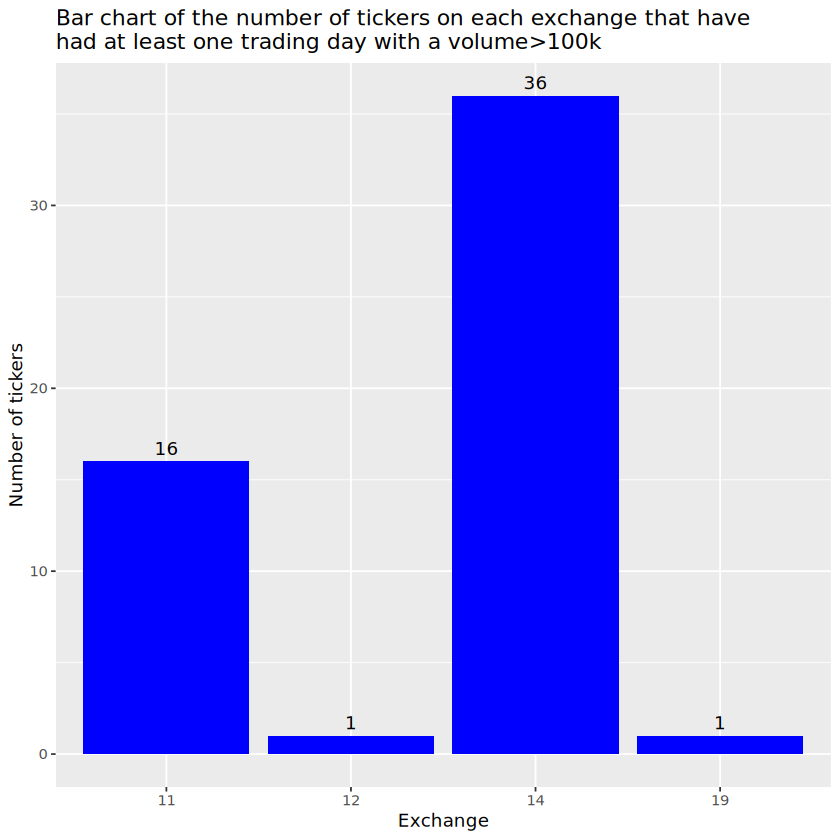

In [44]:
library(dplyr)
library(ggplot2)

compustat_food_bev_data <- read.csv("compustat_food_bev.csv")
compustat_food_bev_data <- filter( compustat_food_bev_data, !is.na(exchg) & !is.na(cshtrd) & !is.na(tic))

grouped <- group_by(compustat_food_bev_data, exchg, tic)

# Does the ticker have at least one trading day with a volume of more than 100k? 
tickers_over_100k <- summarize(grouped, true_or_false = any(cshtrd > 100000),  .groups = "drop")

tickers_over_100k <- filter(tickers_over_100k, true_or_false == TRUE)

counter <- count(tickers_over_100k, exchg, name = "num_of_tickers") # Groups data by exchange in a new column num_of_tickers

# Bar chart: exchanges on x, number of tickers on y
ggplot(counter, aes(x = factor(exchg), y = num_of_tickers)) +
  geom_col(fill = "blue") +
  geom_text(aes(label = num_of_tickers), 
            vjust = -0.5,   # Moves text above the bars
            color = "black") +
  labs(x = "Exchange", y = "Number of tickers", 
  title = "Bar chart of the number of tickers on each exchange that have \nhad at least one trading day with a volume>100k"
  )

## Part 2.2

Visualise on one line plot the close prices of each ticker, over the period.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


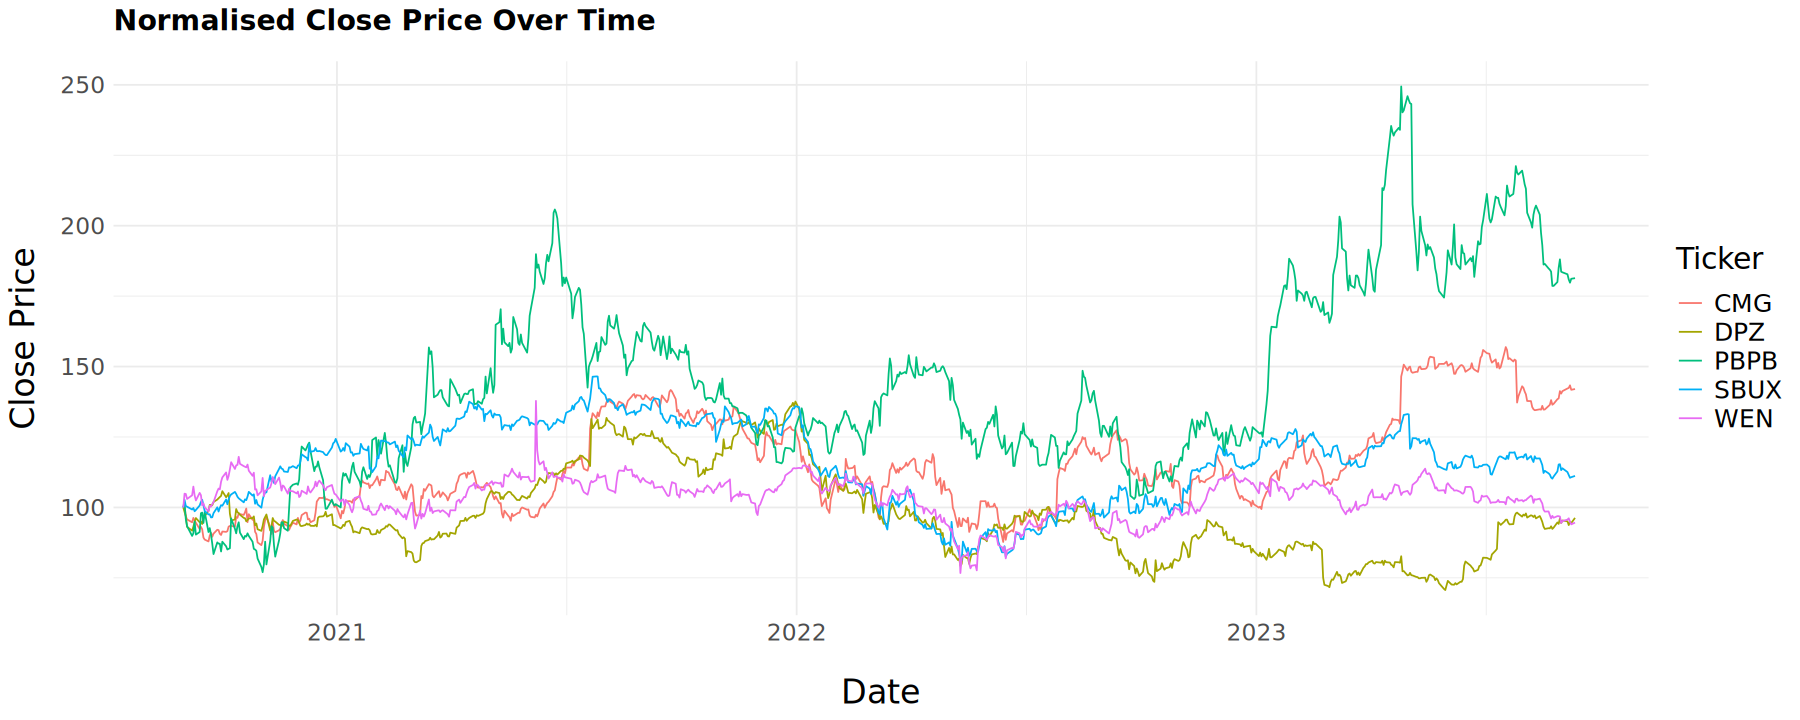

In [45]:
# 

options(repr.plot.width = 15, repr.plot.height = 6)

all_data <- read.csv("compustat_food_bev.csv")

all_data <- all_data %>%
  mutate(datadate = as.Date(datadate, format = "%d/%m/%Y"))

# team12Tickers <- c("CMG", "SBUX", "WEN", "PBPB", "DPZ")

team12Data <- all_data %>%
    filter(tic == "CMG" | tic == "SBUX" | tic == "WEN" | tic == "PBPB" | tic == "DPZ")

team12Normalised <- team12Data %>%
  group_by(tic) %>%
  mutate(relativePrice = prccd / first(prccd) * 100)

ggplot(team12Normalised, aes(x = datadate, y = relativePrice, colour = tic)) +
  geom_line() +
  labs(
    title = "Normalised Close Price Over Time",
    x = "Date",
    y = "Close Price",
    color = "Ticker"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 17, face = "bold", margin = margin(b = 15)),
    axis.title.y = element_text(size = 20, margin = margin(r = 15)),
    axis.title.x = element_text(size = 20, margin = margin(t = 20)),
    axis.text = element_text(size = 14),
    legend.title = element_text(size = 18, margin = margin(b = 10)),
    legend.text = element_text(size = 15)
  )




## Part 2.3

Finally, considering only the ticker you analysed with the highest mean daily return over the period:

Visualise on one line plot the high and low prices, in the year 2021.

For this part, we are going to analyse Potbelly because it has the highest mean daily return over the period analysed.

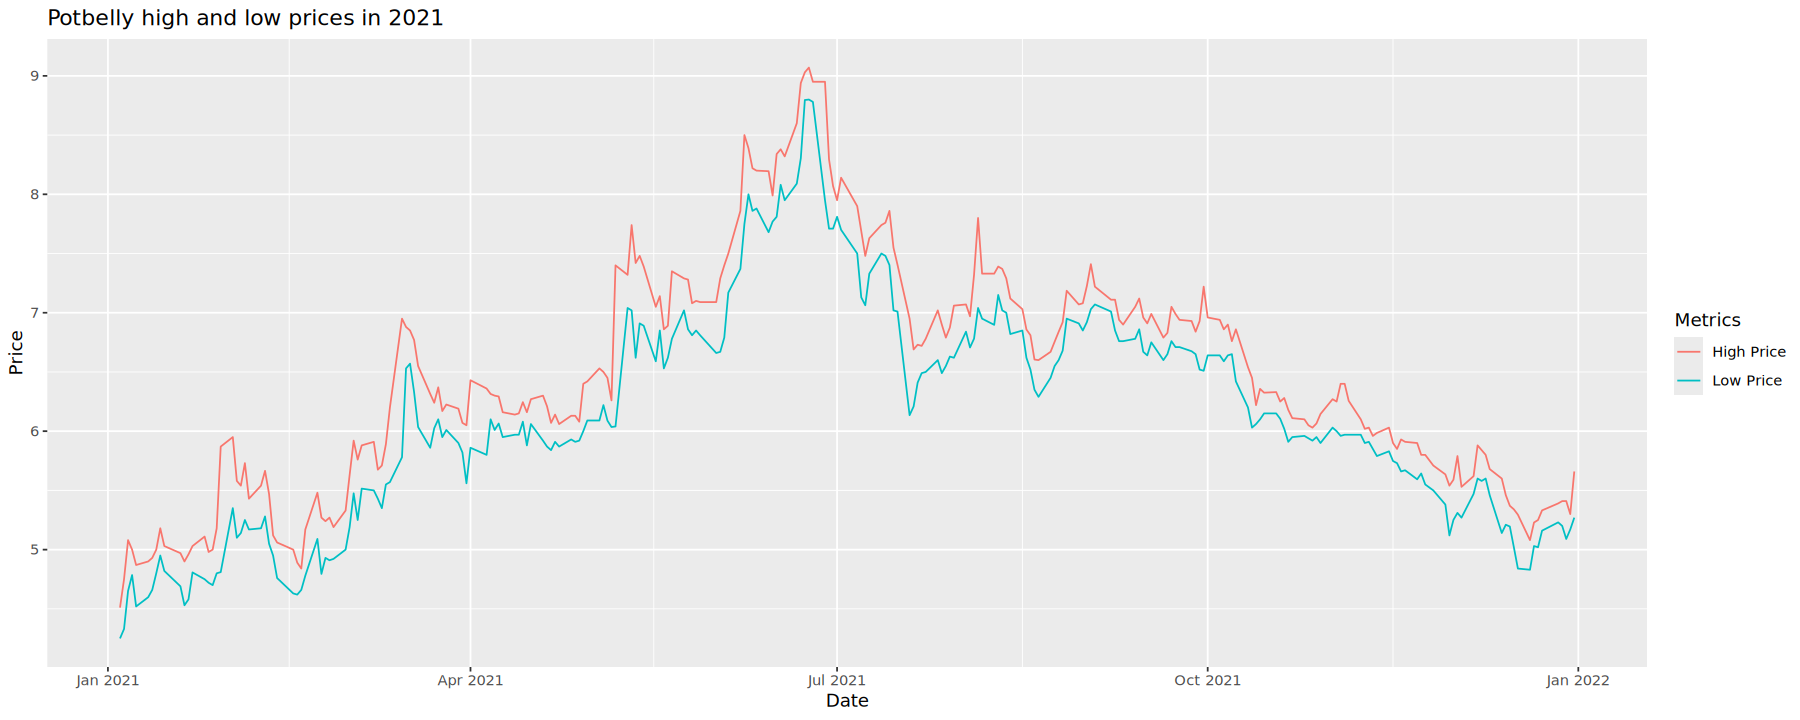

In [46]:
potbelly_2021 <- filter(data_potbelly, year==2021) # Filtering the data of potbelly where year=2021
# Using ggplot we select the data potbelly_2021, in the x-axis the date and in the y axis "prchd", which represent High price
ggplot(data=potbelly_2021, aes(datadate, prchd, colour="High Price")) +
    geom_line() + # We create a line plot
    geom_line(aes(datadate, prcld, colour='Low Price')) + # We add another line plot with the low price
    labs(
        title = "Potbelly high and low prices in 2021",
        x = "Date",
        y = "Price",
        color = "Metrics"
            ) # We add labels

**Interpretation**

In the first half of the year, the stock showed an upward trend, peaking in July 2021 when it reached a high price of approximately $9. After that month, the stock began a downward trend, falling to a low of around $5 by December 2021.

Throughout the period analysed, the stock shows significant volatility, which is indicated by the daily difference between the high and low prices.


## Part 2.4 

Visualise volume using a bar plot, over the entire period.

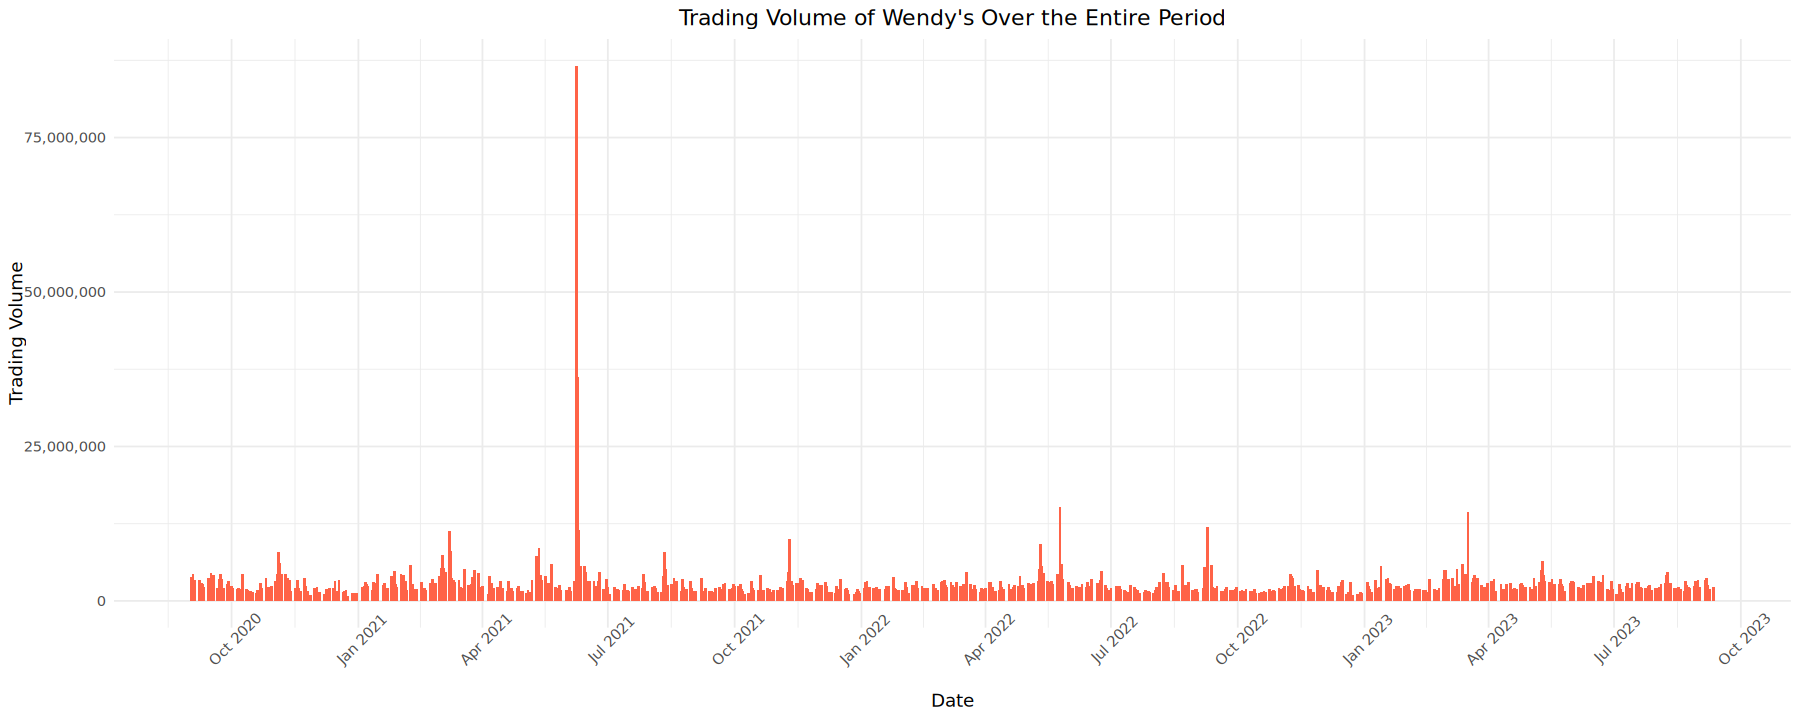

In [47]:
ggplot(wendy, aes(x = datadate, y = cshtrd)) +
  geom_bar(stat = "identity", fill = "tomato", width = 2) + 
  labs(
    title = "Trading Volume of Wendy's Over the Entire Period",
    x = "Date",
    y = "Trading Volume"
  ) +
  scale_y_continuous(labels = scales::comma) +
  expand_limits(y = max(wendy$cshtrd)) +
  scale_x_date(date_breaks = "3 months", date_labels = "%b %Y") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45),
        plot.title = element_text(hjust = 0.5))

## Part 2.5 

Visualise using scatter plot, the relationship between simple daily returns and volume in the year of 2021

For this part, we are going to analyse **Potbelly** because it has the highest mean daily return over the period analysed.

Firstly, we filter the data for 2021 and then visualize the data using scatter plot, with `Daily Returns` on x-axis and `Volume` on y-axis. We also add linear regression line.

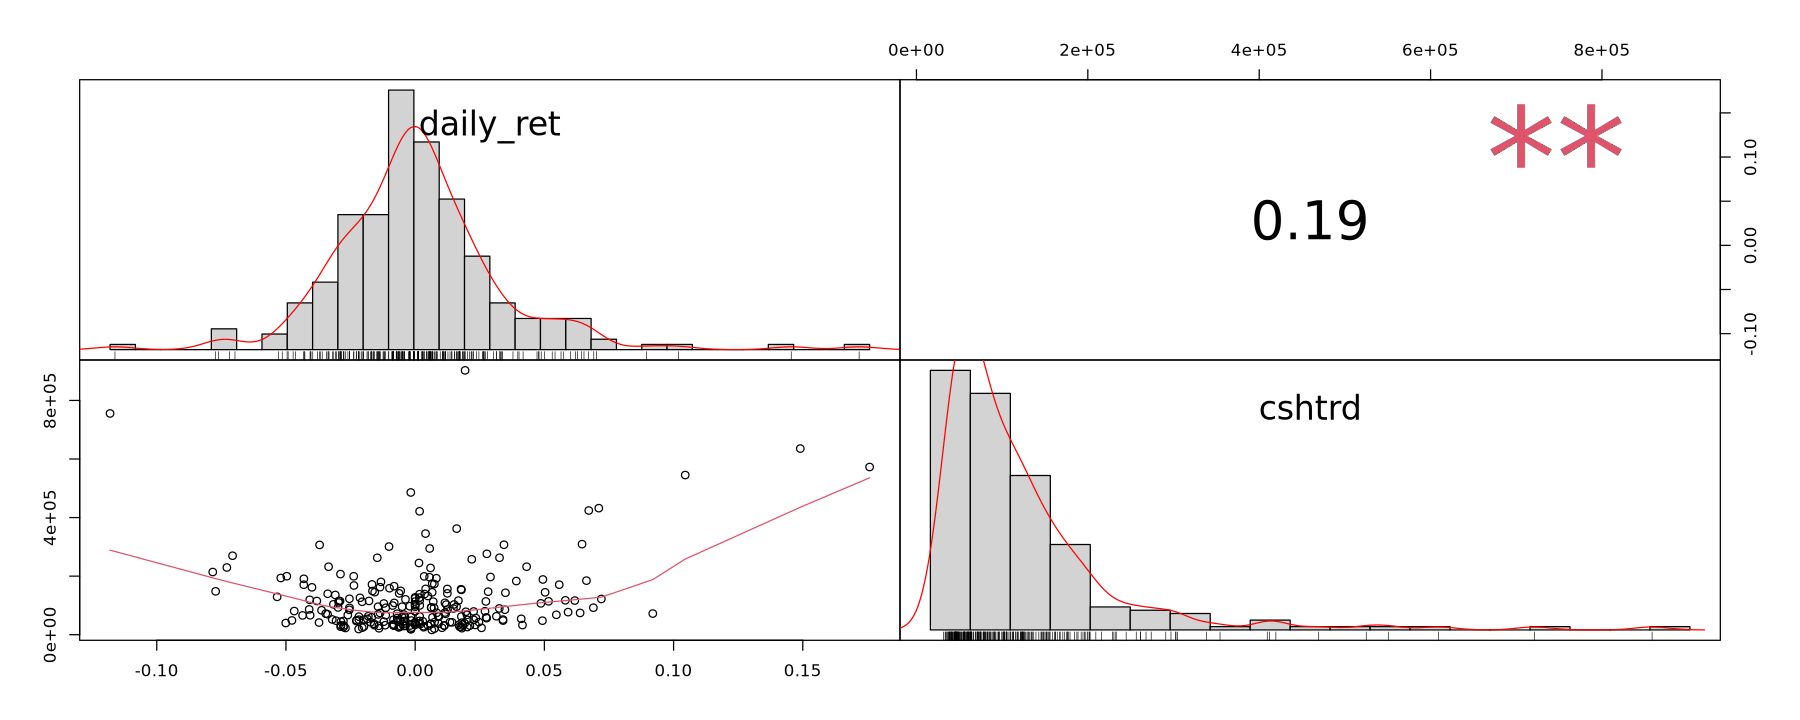

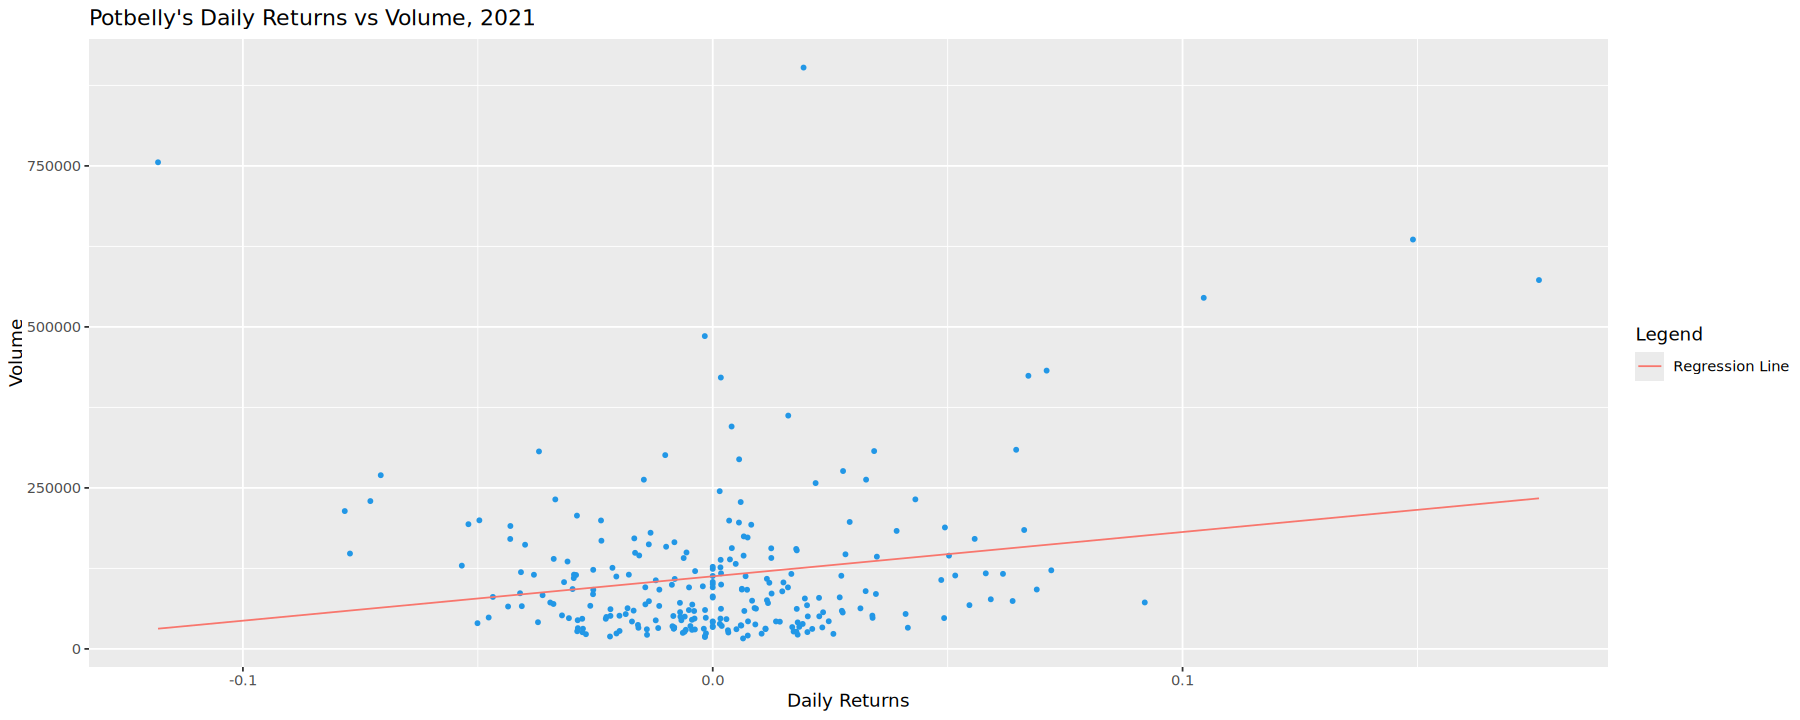

In [48]:
data_potbelly_2021 <- filter(data_potbelly, year == 2021)
chart.Correlation(select(data_potbelly_2021, daily_ret, cshtrd))

lm_ret_vol <- lm(formula= cshtrd ~ daily_ret, data = data_potbelly_2021)

data_potbelly_2021 <- na.omit(data_potbelly_2021)
data_potbelly_2021$model_prediction <- predict(lm_ret_vol)

ggplot(data_potbelly_2021, aes(x = daily_ret, y = cshtrd)) + # this is main data
    geom_point(size=1, color = 4) +                       # this is scatter plot of above data
    geom_line(aes(x = daily_ret, y = model_prediction, colour = "Regression Line")) +
    labs(title = "Potbelly's Daily Returns vs Volume, 2021",
        x = "Daily Returns", y = "Volume",
        colour = "Legend",)

From the above chart, we observed that:
- The daily return is clustering around zero. Most values fall within range of -8% to +10%.
- The daily trading volumes are generally stable, mostly below ~500k. However there are outliers:
    - There is a sharp spike to ~900k, with average daily return value
    - There 4 other outliers with considerably high volume, with 3 of them have quite large daily return of more than ~10% each day, and 1 has unusually low daily return of -12%
- The scatter plot doesn’t show a clear upward or downward slope/trend, and we may say that there is no (linear) relationship between daily return and volume. However, the regression line shows a positive slope (though with weak strength), and this is possibly affected by the outliers with high volume and high daily return mentioned before.

Now, we will try to visualize the data by excluding those outliers.

First, we want to see the exact values of the outliers, by seing the head and tail of column `cshtrd` and `daily_ret`. Why head & tail? Because those area are where the outliers are.

In [53]:
head(data_potbelly_2021 %>% arrange(desc(cshtrd)), 5)

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_ret,overnight_ret,change_open_close,mfv,month,year,model_prediction
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,18839,1,2021-03-12,PBPB,POTBELLY CORP,902667,5.80,6.2000,5.5700,5.74,14,5812,0.01933216,0.008787346,0.06,-243576.81,3,2021,126021.69
2,18839,1,2021-07-19,PBPB,POTBELLY CORP,755598,6.20,6.9500,6.1350,6.95,14,5812,-0.11806543,-0.011379801,-0.75,-635073.17,7,2021,31428.12
3,18839,1,2021-05-07,PBPB,POTBELLY CORP,635653,7.17,7.4000,6.0398,6.29,14,5812,0.14903846,0.008012821,0.88,420684.33,5,2021,215320.07
4,18839,1,2021-03-15,PBPB,POTBELLY CORP,572707,6.82,6.9500,5.7800,5.78,14,5812,0.17586207,-0.003448276,1.04,445438.78,3,2021,233787.21
5,18839,1,2021-01-29,PBPB,POTBELLY CORP,545145,5.39,5.8699,4.8100,5.05,14,5812,0.10450820,0.034836066,0.34,51485.06,1,2021,184662.49


In [54]:
head(data_potbelly_2021 %>% arrange(desc(daily_ret)), 5)

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_ret,overnight_ret,change_open_close,mfv,month,year,model_prediction
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,18839,1,2021-03-15,PBPB,POTBELLY CORP,572707,6.82,6.9500,5.7800,5.78,14,5812,0.17586207,-0.003448276,1.04,445438.78,3,2021,233787.2
2,18839,1,2021-05-07,PBPB,POTBELLY CORP,635653,7.17,7.4000,6.0398,6.29,14,5812,0.14903846,0.008012821,0.88,420684.33,5,2021,215320.1
3,18839,1,2021-01-29,PBPB,POTBELLY CORP,545145,5.39,5.8699,4.8100,5.05,14,5812,0.10450820,0.034836066,0.34,51485.06,1,2021,184662.5
4,18839,1,2021-01-05,PBPB,POTBELLY CORP,72136,4.75,4.7500,4.3300,4.33,14,5812,0.09195402,-0.004597701,0.42,72136.00,1,2021,176019.4
5,18839,1,2021-05-21,PBPB,POTBELLY CORP,122029,7.29,7.3500,6.7800,6.84,14,5812,0.07205882,0.005882353,0.45,96338.68,5,2021,162322.2


In [55]:
tail(data_potbelly_2021 %>% arrange(desc(daily_ret)), 5)

,GVKEY,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,exchg,sic,daily_ret,overnight_ret,change_open_close,mfv,month,year,model_prediction
,<int>,<int>,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
248,18839,1,2021-03-19,PBPB,POTBELLY CORP,269708,6.05,6.55,6.035,6.53,14,5812,-0.07066052,0.003072197,-0.48,-253996.85,3,2021,64064.79
249,18839,1,2021-05-12,PBPB,POTBELLY CORP,229527,6.87,7.42,6.620,7.29,14,5812,-0.07287449,-0.016194332,-0.42,-86072.62,5,2021,62540.55
250,18839,1,2021-02-23,PBPB,POTBELLY CORP,148060,4.90,5.27,4.795,5.27,14,5812,-0.07721281,-0.007532957,-0.37,-82601.89,2,2021,59553.77
251,18839,1,2021-06-28,PBPB,POTBELLY CORP,214029,8.12,8.95,7.950,8.80,14,5812,-0.07832009,-0.001135074,-0.68,-141259.14,6,2021,58791.44
252,18839,1,2021-07-19,PBPB,POTBELLY CORP,755598,6.20,6.95,6.135,6.95,14,5812,-0.11806543,-0.011379801,-0.75,-635073.17,7,2021,31428.12


Here we clean the data and then visualize to see the relationship between the 2 variables.

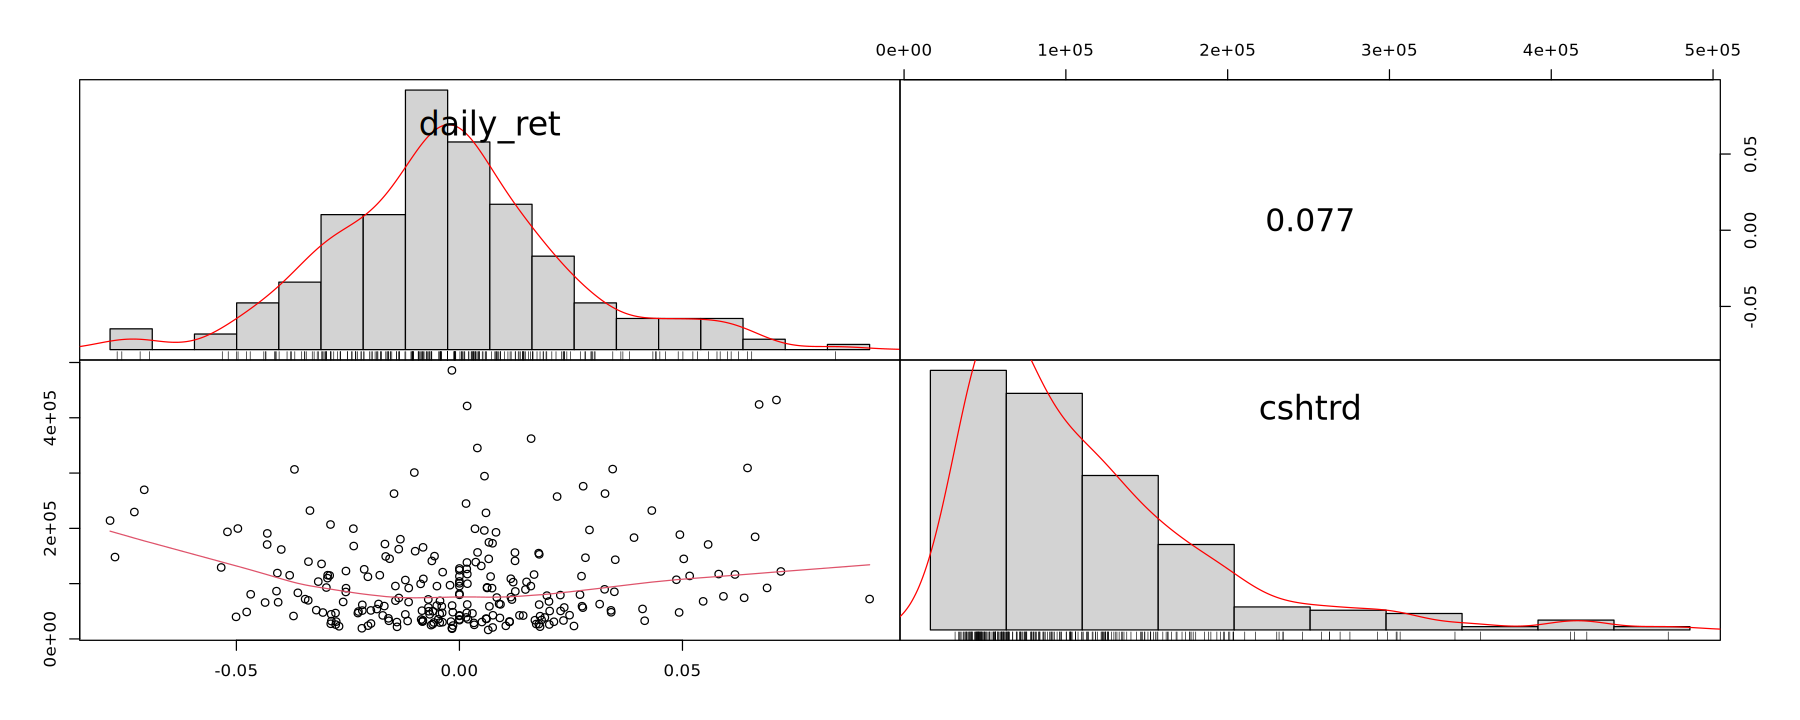

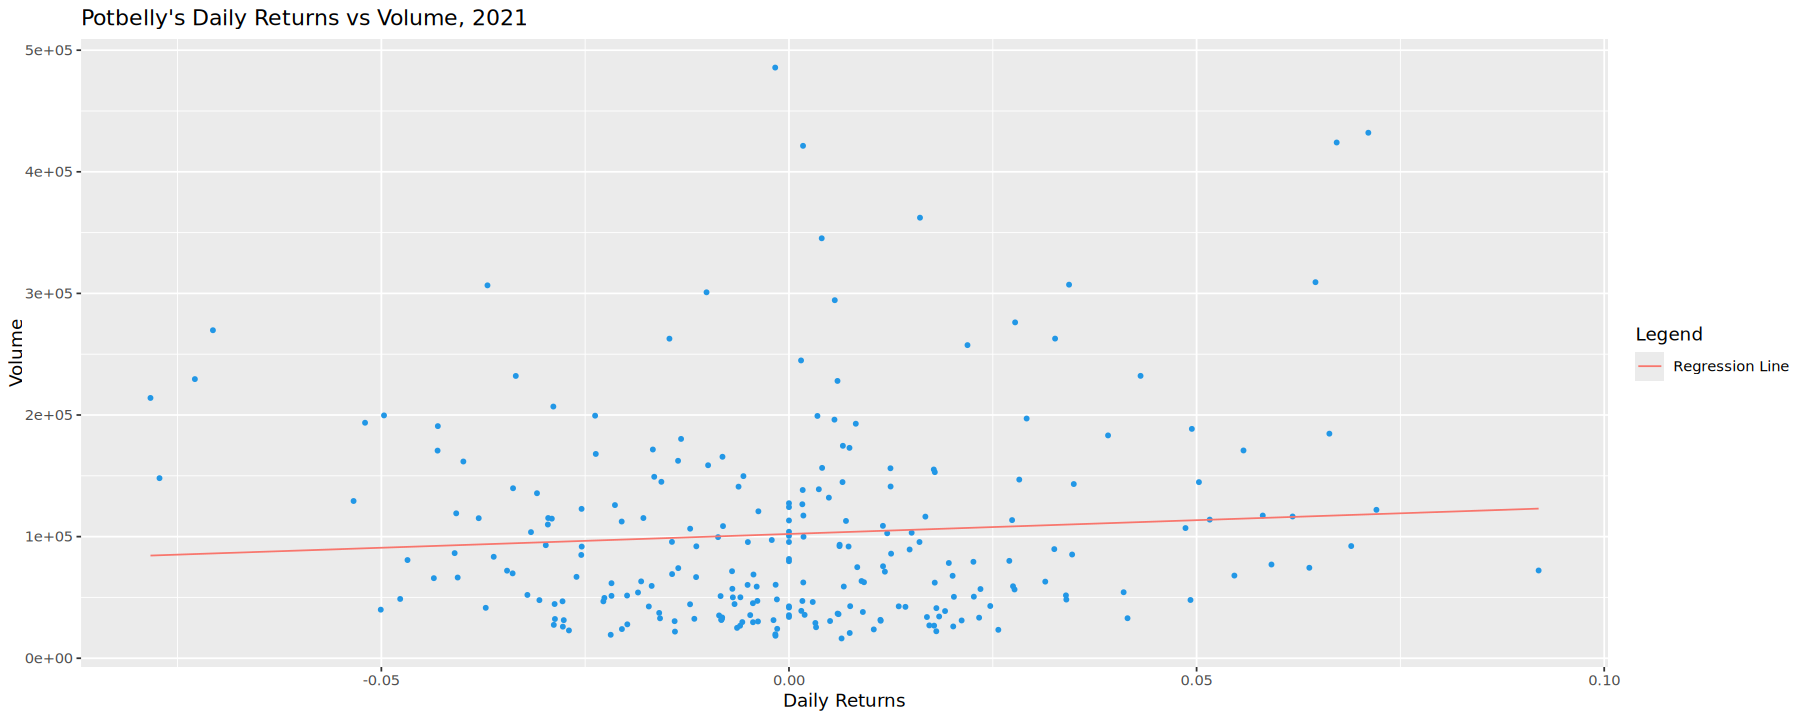

In [56]:
data_potbelly_2021_clean <- filter(data_potbelly_2021, cshtrd < 750000, daily_ret < 0.1, daily_ret > -0.8)
chart.Correlation(select(data_potbelly_2021_clean, daily_ret, cshtrd))

lm_ret_vol_2 <- lm(formula= cshtrd ~ daily_ret, data = data_potbelly_2021_clean)

data_potbelly_2021_clean <- na.omit(data_potbelly_2021_clean)
data_potbelly_2021_clean$model_prediction <- predict(lm_ret_vol_2)

ggplot(data_potbelly_2021_clean, aes(x = daily_ret, y = cshtrd)) + # this is main data
    geom_point(size=1, color = 4) +                             # this is scatter plot of above data
    geom_line(aes(x = daily_ret, y = model_prediction, colour = "Regression Line")) +
    labs(title = "Potbelly's Daily Returns vs Volume, 2021",
        x = "Daily Returns", y = "Volume",
        colour = "Legend",)

Removing the outlier significantly affect how we can interpret the scatter plot and the regression line.
Here, we can see that the daily return and volume are not linearly correlated.

# References

Chipotle Mexican Grill (2023), CHIPOTLE ACCELERATES INTERNATIONAL EXPANSION THROUGH FIRST-EVER DEVELOPMENT AGREEMENT WITH ALSHAYA GROUP IN MIDDLE EAST. Available at: https://newsroom.chipotle.com/2023-07-18-CHIPOTLE-ACCELERATES-INTERNATIONAL-EXPANSION-THROUGH-FIRST-EVER-DEVELOPMENT-AGREEMENT-WITH-ALSHAYA-GROUP-IN-MIDDLE-EAST?utm_source=chatgpt.com (Accessed: 1st October 2025)

Duprey, R. (2021) Wendy's is Suddenly a Meme Stock. Available at: https://www.nasdaq.com/articles/wendys-is-suddenly-a-meme-stock-2021-06-08 (Accessed: 25 September 2025)

Potbelly Corporation (2023) *Potbelly Corporation provides First Quarter 2023 business update*. Available at: [https://investors.potbelly.com/news-releases/news-release-details/potbelly-corporation-provides-first-quarter-2023-business-update](https://investors.potbelly.com/news-releases/news-release-details/potbelly-corporation-provides-first-quarter-2023-business-update) (Accessed: 2 October 2025).

Potbelly Corporation (2023) *Potbelly advances franchise growth acceleration initiative with strategic refranchising in 2023*. PR Newswire, 20 April. Available at: [https://www.prnewswire.com/news-releases/potbelly-advances-franchise-growth-acceleration-initiative-with-strategic-refranchising-in-2023-301802603.html](https://www.prnewswire.com/news-releases/potbelly-advances-franchise-growth-acceleration-initiative-with-strategic-refranchising-in-2023-301802603.html) (Accessed: 2 October 2025).

Potbelly Corporation (2023) *Potbelly Corporation continues growth in Florida with new shop*. Available at: [https://investors.potbelly.com/news-releases/news-release-details/potbelly-corporation-continues-growth-florida-new-shop](https://investors.potbelly.com/news-releases/news-release-details/potbelly-corporation-continues-growth-florida-new-shop) (Accessed: 2 October 2025).

Potbelly Corporation (2025) *Potbelly Corporation reports results for fourth fiscal quarter and full year 2024*. Available at: [https://investors.potbelly.com/news-releases/news-release-details/potbelly-corporation-reports-results-fourth-fiscal-quarter-and-5](https://investors.potbelly.com/news-releases/news-release-details/potbelly-corporation-reports-results-fourth-fiscal-quarter-and-5) (Accessed: 2 October 2025).